# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [7]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [2]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")
type(mapbox_token)

str

# Import Data

In [3]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

This will make it easier to build and modify the layout later. Each function should return the plot figure in a format that Panel can use to plot the visualization.

In [58]:
# Define Panel Visualization Functions

def housing_units_per_year():
    """Housing Units Per Year."""
    df = sfo_data.groupby(by='year')['housing_units'].mean()
    
    #get ylim vals
    maxy = max(df + df.std())
    miny = min(df - df.std())

    fig = df.plot(kind='bar', 
                   figsize=(6,4),
                   title='Housing Units in San Francisco from 2010 to 2016',
                   ylim=(miny,maxy)
                  ).figure

    plt.close(fig)
    return fig

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    df = sfo_data.groupby(by='year')['sale_price_sqr_foot','gross_rent'].mean()
    fig = df['gross_rent'].plot(title='Average Gross Rent in San Francisco').figure
    
    plt.close(fig)
    return fig


def average_sales_price():
    """Average Sales Price Per Year."""
    df = sfo_data.groupby(by='year')['sale_price_sqr_foot','gross_rent'].mean()
    fig = df['sale_price_sqr_foot'].plot(title='Average Sale Price per Square Foot in San Francisco').figure
    
    plt.close(fig)
    return fig
        


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    df = sfo_data.groupby(by=['year','neighborhood']).mean()
    return df.hvplot(x='year',y='sale_price_sqr_foot',groupby='neighborhood')
    


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    top_10 = sfo_data.groupby(by='neighborhood').mean().sort_values('sale_price_sqr_foot',ascending=False)[0:10]
    top_10.reset_index(inplace=True)
    
    std = top_10['sale_price_sqr_foot'].std()
    miny = min(top_10['sale_price_sqr_foot'] - std)
    maxy = max(top_10['sale_price_sqr_foot'] + std)

 
    return top_10.hvplot.bar(
            x="neighborhood", 
            y="sale_price_sqr_foot", 
            title = "Top 10 Most Expensive Neighborhoods in San Francisco",
            height=500,
            rot=90,
            ylim=(miny,maxy)
        )


def parallel_coordinates():
    """Parallel Coordinates Plot."""
    top_10 = None
    top_10 = sfo_data.groupby(by='neighborhood').mean().sort_values('sale_price_sqr_foot',ascending=False)[0:10]
    top_10.reset_index(inplace=True)
    return px.parallel_coordinates(top_10, 
                                   color='sale_price_sqr_foot')
    

def parallel_categories():
    """Parallel Categories Plot."""
    top_10 = sfo_data.groupby(by='neighborhood').mean().sort_values('sale_price_sqr_foot',ascending=False)[0:10]
    top_10.reset_index(inplace=True)
    return px.parallel_categories(top_10, color='sale_price_sqr_foot')
    

def neighborhood_map():
    """Neighborhood Map"""
    # Calculate the mean values for each neighborhood
    df_avgs = sfo_data.groupby(by='neighborhood').mean()
    df_avgs.reset_index(inplace=True)
    
    # Join the average values with the neighborhood locations
    df_neighborhoods = pd.concat([df_neighborhood_locations,df_avgs],axis='columns')
    df_neighborhoods.drop(columns='neighborhood',inplace=True)

    
    px.set_mapbox_access_token(mapbox_token)
    return px.scatter_mapbox(df_neighborhoods,
                  lat='Lat', 
                  lon='Lon', 
                  size='sale_price_sqr_foot',
                  color='gross_rent',
                  title='Average Sale Price per Square Foot and Gross Rent in San Francisco',
                  zoom=10
                 )




## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive09813')
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
    [2] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
        [2] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
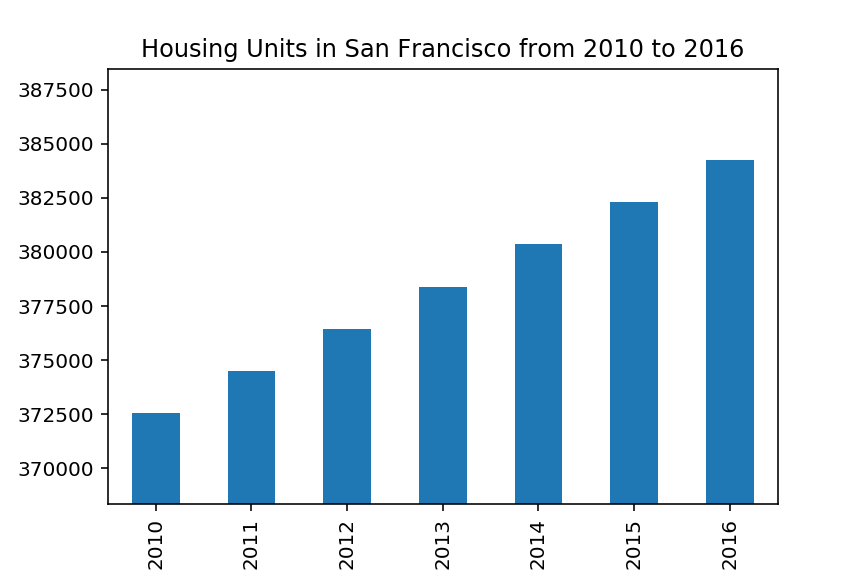
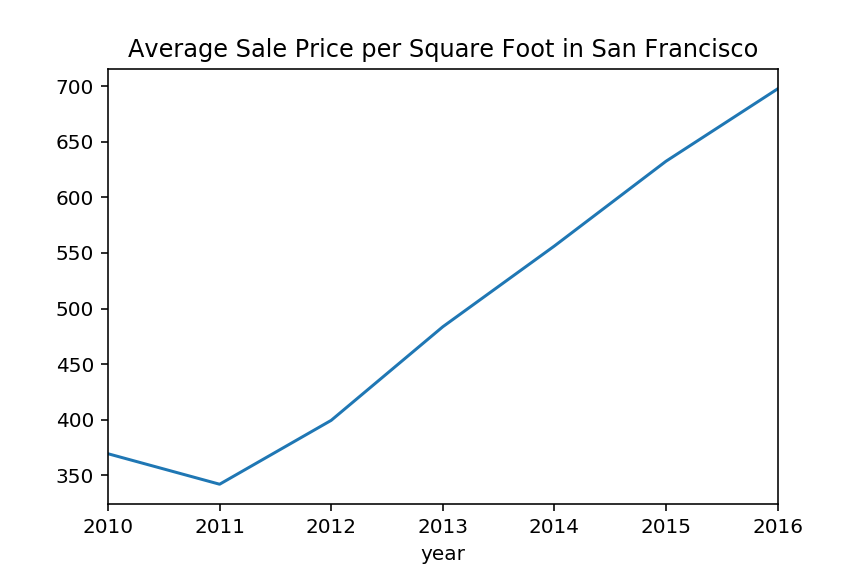
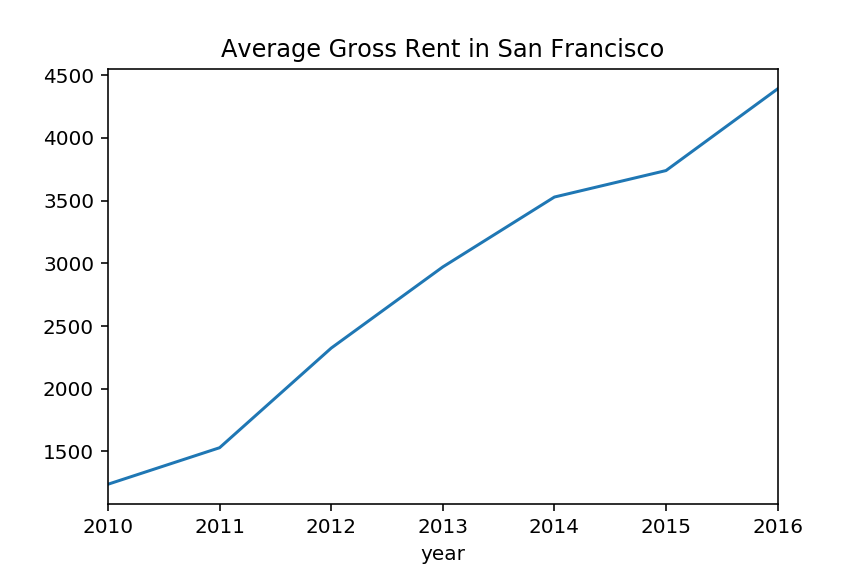

In [59]:
#welcome
maps = pn.Row(neighborhood_map)
welcome = pn.Column(
    ('#Welcome - glad you are here'),
    maps
)

#Yearl Market Analysis
yearly_market_analysis_row = pn.Row(housing_units_per_year(),
                                   average_gross_rent(),
                                   average_sales_price()
                                   )

yearly_market_analysis = pn.Column(
    '#Yearly Market Analysis',
    yearly_market_analysis_row
)

#Neigbhorhood Analysis
neighborhood_analysis = pn.Column(
    '# Neighborhood Analysis Intro',
    top_most_expensive_neighborhoods(),
    average_price_by_neighborhood()
    
)

#parallel plots
parallel_plots = pn.Column(
    '# Parallel Plots Intro',
    parallel_coordinates(),
    parallel_categories()
)


tabs = pn.Tabs(
    ('Welcome',welcome),
    ('Yearly Market Analysis',yearly_market_analysis),
    ('Neighborhood Analyis',neighborhood_analysis),
    ('Parallel Plots Anaylis',parallel_plots)
)

tabs


## Serve the Panel Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] Column
                [0] Column()
                [1] Row
                    [0] Plotly(Figure, name='interactive09813')
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Matplotlib(Figure)
    [2] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
        [2] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Cow Hollow', width=250)
                [1] VSpacer()
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
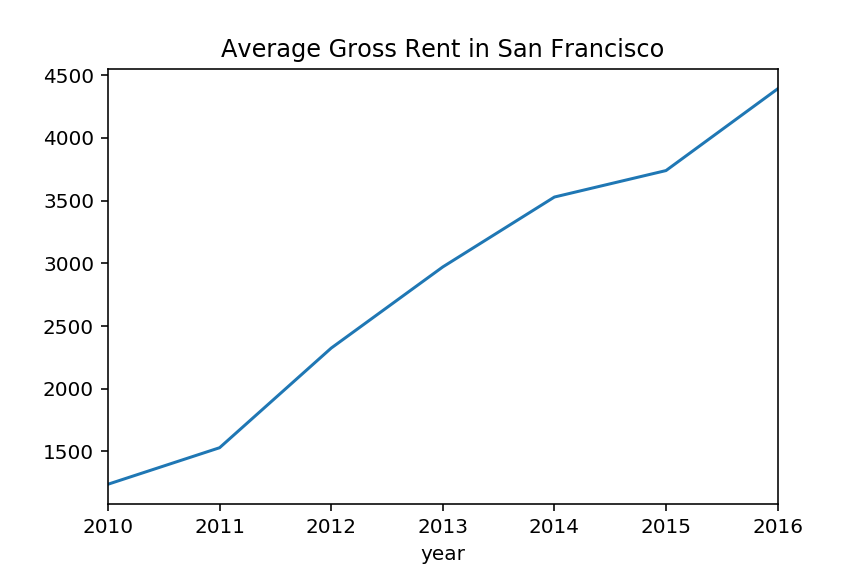
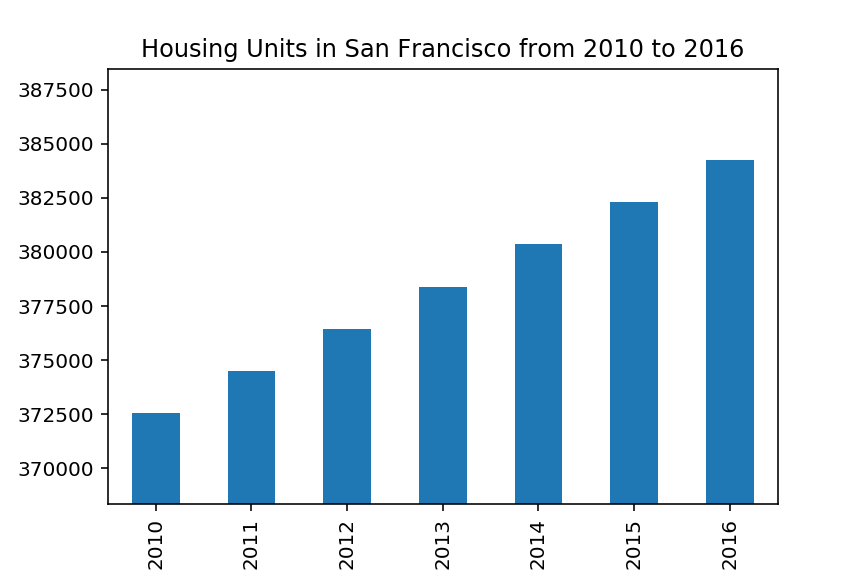
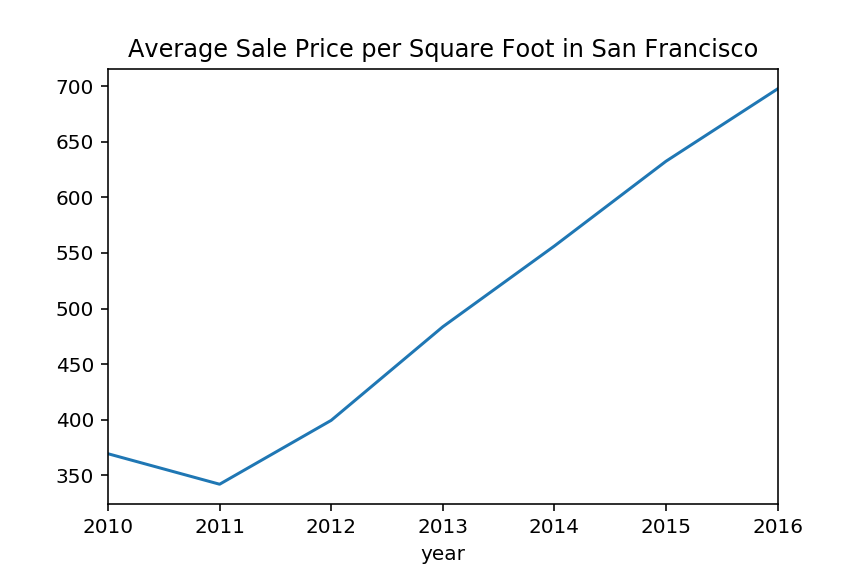

In [61]:
tabs.servable()